In [1]:
filename = 'uv2019082119'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
#from pylab import *

def write_uv():
    """Write NetCDF file for GNOME"""
    
    input_fname = '../data/' + filename + '.nc'
    output_fname = '../data/gnome_' + filename + '.nc'
    
    def read_uv(input_fname):
        """Read NetCDF file"""
        fh = Dataset(input_fname, mode='r')
        lat = fh.variables['lat'][:]
        lon = fh.variables['lon'][:]
        time = fh.variables['time'][:]
        water_u = fh.variables['water_u'][:]
        water_v = fh.variables['water_v'][:]
        time_unit = fh.variables['time'].units
        fh.close()

        lon -= 360.0
        return (lat, lon, time, water_u, water_v, time_unit)
    
    # get data  
    lat_arr, lon_arr, time_arr, water_u_arr, water_v_arr, time_unit = read_uv(input_fname)
    numlat = lat_arr.count()
    numlon = lon_arr.count()

    # create file
    ncfile = Dataset(output_fname,'w',format='NETCDF3_CLASSIC')
    #ncfile = Dataset(output_fname,'w',format='NETCDF4')

    # create dimensions
    ncfile.createDimension('lat', numlat)
    ncfile.createDimension('lon', numlon)
    ncfile.createDimension('time', None)  # UNLIMITED  

    # define variables
    lat = ncfile.createVariable('lat', 'f4', ('lat',))
    lon = ncfile.createVariable('lon', 'f4', ('lon',))
    time = ncfile.createVariable('time', 'd', ('time',))
    water_u = ncfile.createVariable('water_u', 'f4', ('time','lat','lon'), fill_value=999999)
    water_v = ncfile.createVariable('water_v', 'f4', ('time','lat','lon'), fill_value=999999)

    # add attributes to variables
    lat.long_name = 'Latitude'
    lat.units = 'degrees_north'
    lat.point_spacing = 'even'
    lon.long_name = 'Longitude'
    lon.units = 'degrees_east'
    lon.point_spacing = 'even'

    time.long_name = 'Valid Time'
    time.units = time_unit[:-8]

    water_u.long_name = 'Eastward Water Velocity'
    water_u.units = 'm/s'
    water_v.long_name = 'Northward Water Velocity'
    water_v.units = 'm/s'

    # add global attributes
    ncfile.grid_type = "regular"

    # populte the variables with data
    time[:] = time_arr.filled()
    lon[:] = lon_arr.filled()
    lat[:] = lat_arr.filled()
    water_u[:] = water_u_arr.filled().squeeze()
    water_v[:] = water_v_arr.filled().squeeze()

    # close ncfile
    ncfile.close()
    

def read_data(filename):
    """Read NetCDF file for interpolation"""
    nc_file = filename
    fh = Dataset(nc_file, mode='r')
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    depth = fh.variables['depth'][:]
    time = fh.variables['time'][:]
    U  = fh.variables['water_u'][:]
    V  = fh.variables['water_v'][:]
    time_unit = fh.variables['time'].units
    fh.close()
    
    lons, lats = np.meshgrid(lons, lats)
    lons -= 360.0    
    return (time,time_unit,lons,lats,depth,U,V)


def plot_uv(var, lats, lons):
    plt.figure()   
    m = Basemap(projection='cyl',llcrnrlat=lats.min(),urcrnrlat=lats.max(),llcrnrlon=lons.min(),urcrnrlon=lons.max(),lat_ts=10,resolution='h')
    x, y = m(lons,lats)
    cs = m.contourf(x, y, var, cmap='coolwarm')
    m.drawparallels(np.arange(-90.,120.,1.), labels=[1,0,0,0], linewidth=0)
    m.drawmeridians(np.arange(-180.,180.,1.), labels=[0,0,0,1],linewidth=0)
    m.drawcoastlines()
    m.colorbar(cs,location='bottom',pad='10%')
    #plt.title('Velocity at the surface (U: m/s)')
    plt.show()
    

def dd2dms(dd1,dd2,ndec=6):  
    """
    Convert a decimal degree coordinate pair to a six-tuple of degrees, minutes seconds.
    The returned values are not rounded.  
      
    Arguments:
    dd1, dd2 - coordinate pair, in decimal degrees  
        
    Example:
      >>> dd2dms(-74.25,32.1)  
      (-74, 15, 6.9444444444444444e-05, 32, 6, 2.7777777777778172e-05)  
    """  
    # Author: Curtis Price, http://profile.usgs.gov/cprice  
    # Disclaimer: Not approved by USGS. (Provisional, subject to revision.)      
    def ToDMS(dd):  
        dd1 = abs(float(dd))  
        cdeg = int(dd1)  
        minsec = dd1 - cdeg  
        cmin = int(minsec * 60)  
        csec = (minsec % 60) / float(3600)      
        if dd < 0: cdeg = cdeg * -1  
        return cdeg,cmin#,csec   # CHAKO
      
    try:  
        # return a six-tuple  
        return ToDMS(dd1) + ToDMS(dd2)             
    except:  
        raise Exception("Invalid input")
        
        
def dms2dd(deg1,min1,sec1,deg2,min2,sec2):  
    """
    Convert a degrees-minutes seconds coordinate pair to decimal degrees.  
    The returned values are not rounded.  
          
    Arguments:
      deg1,min1,sec1,deg2,min2,sec2 - DMS coordinate pair (six values)  
      
    Example:
      >>> dms2deg(-74,45,0,34,10,20)  
      (-74.75, 34.172222222222217)  
    """  
    # Author: Curtis Price, http://profile.usgs.gov/cprice  
    # Disclaimer: Not approved by USGS. (Provisional, subject to revision.)      
    def ToDD(deg,min=0,sec=0):  
        dd = abs(deg) + min / 60.0 + sec / 3600.0  
        if deg < 0:  
            dd = dd * -1.0  
        return dd  
    try:  
        return ToDD(deg1,min1,sec1), ToDD(deg2,min2,sec2)  
    except Exception:  
        raise Exception("Invalid input")

### (1) Read in NetCDF file, and write out to a new NetCDF file as required by GNOME

In [3]:
# read in and write out NetCDF files
write_uv()

### (2.1) Read in NetCDF file

In [4]:
# Read data and take daily mean
time_arr, time_unit, lons, lats, depth, u, v = read_data('../data/' + filename + '.nc')
umean = np.mean(u, axis=0).squeeze()
vmean = np.mean(v, axis=0).squeeze()

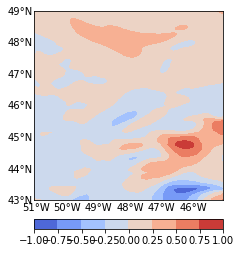

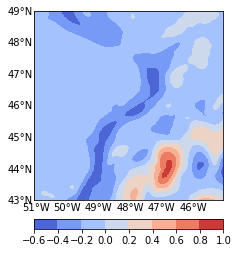

In [5]:
# Plot U, V
plot_uv(umean, lats, lons)
plot_uv(vmean, lats, lons)

### (2.2) Interpolate u, v

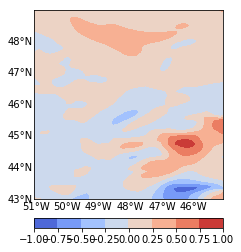

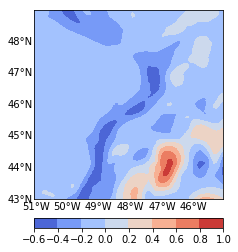

In [6]:
# Interpolate u, v onto higher resolution grids
from scipy.interpolate import griddata

# 1d high resolution grids
hlons = np.arange(lons.min(), lons.max(), 0.016667)
hlats = np.arange(lats.min(), lats.max(), 0.016667)

# convert to 2d meshgrids
hlons2d, hlats2d = np.meshgrid(hlons, hlats)

# set mask
#mask = (hlons > 0.5) & (hlons < 0.6) & (hlats > 0.5) & (hlats < 0.6)

# interpolate
humean = griddata((lons.flatten(), lats.flatten()), umean.flatten(), (hlons2d, hlats2d), method='linear')
hvmean = griddata((lons.flatten(), lats.flatten()), vmean.flatten(), (hlons2d, hlats2d), method='linear')

# mask out the field
#humean[mask] = np.nan
#hvmean[mask] = np.nan

# plot new field
plot_uv(humean, hlats2d, hlons2d)
plot_uv(hvmean, hlats2d, hlons2d)

### (2.3) Write interpolated data to new NetCDF file

In [7]:
# Write interpolated data to netcdf file
gnome_filename = 'gnome_' + filename + '_constant.nc'
ncfile = Dataset('../data/'+gnome_filename,'w',format='NETCDF3_CLASSIC')

# create dimensions
ncfile.createDimension('lat', hlats.size)
ncfile.createDimension('lon', hlons.size)
ncfile.createDimension('time', None)  # UNLIMITED  

# define variables
lat = ncfile.createVariable('lat', 'f4', ('lat',))
lon = ncfile.createVariable('lon', 'f4', ('lon',))
time = ncfile.createVariable('time', 'd', ('time',))
water_u = ncfile.createVariable('water_u', 'f4', ('time','lat','lon'), fill_value=999999)
water_v = ncfile.createVariable('water_v', 'f4', ('time','lat','lon'), fill_value=999999)

# add attributes to variables
lat.long_name = 'Latitude'
lat.units = 'degrees_north'
lat.point_spacing = 'even'
lon.long_name = 'Longitude'
lon.units = 'degrees_east'
lon.point_spacing = 'even'

time.long_name = 'Valid Time'
#time.units = time_unit[:-8]

water_u.long_name = 'Eastward Water Velocity'
water_u.units = 'm/s'
water_v.long_name = 'Northward Water Velocity'
water_v.units = 'm/s'

# add global attributes
ncfile.grid_type = "regular"
#ncfile.history = "Created " + datetime.datetime.today().strftime("%d/%m/%y")    

# populte the variables with data
lat[:] = hlats
lon[:] = hlons
time[:] = time_arr
for i in range(time_arr.size):
    water_u[i] = humean.reshape(hlons.size, hlats.size)
    water_v[i] = hvmean.reshape(hlons.size, hlats.size)

ncfile.close()

### (2.4) Write interpolated data to CSV file for OilMap

In [8]:
# Convert decimal degrees to degree, minute, and second
hlats2d = hlats2d.flatten()
hlons2d = hlons2d.flatten()
latlon = []
for i in range(len(hlons2d)):
    latlon.append(dd2dms(hlats2d[i], hlons2d[i]))

In [9]:
# Write uv to file
latlon = np.asarray(latlon)
humean = humean.flatten()
hvmean = hvmean.flatten()

#data = np.column_stack((latlon, hlats2d, hlons2d, humean, hvmean))
data = np.column_stack((latlon, humean, hvmean))
np.savetxt('../data/' + filename + '.csv', data, delimiter=" ", fmt='%1.2f')

### (3) Select part of the data

In [10]:
# Convert ndarry to DataFrame and filter longitude and latitude
#import pandas as pd
#df = pd.DataFrame(data=data, columns=['lat_deg', 'lat_min', 'lon_deg', 'lon_min', 'lat', 'lon', 'u', 'v'])

# filter lon and lat to get a desired regions
#df = df.loc[(df['lat']>=46.4) & (df['lat']<=46.8) & (df['lon']<=-48.2) & (df['lon']>=-48.8)]
#df = df.iloc[::4, :]  # every 4th row

# write to csv
#df.to_csv('../data/' + filename + '_region.csv', sep='\t')